Install and load packages

In [2]:
!pip install shap -qq

In [3]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import lasso_path
import xgboost
import shap


Get data

In [14]:
milan = pd.read_csv('http://data.insideairbnb.com/italy/lombardy/milan/2023-03-19/data/listings.csv.gz', header=0, encoding='latin-1', sep=',', decimal='%', parse_dates=[0], dayfirst=True)
pd.set_option('display.max_columns', None)
milan.head()


/tmp/ipython-input-3848771318.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  milan = pd.read_csv('http://data.insideairbnb.com/italy/lombardy/milan/2023-03-19/data/listings.csv.gz', header=0, encoding='latin-1', sep=',', decimal='%', parse_dates=[0], dayfirst=True)


,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,5678774,https://www.airbnb.com/rooms/5678774,20230319041241,2023-03-19,previous scrape,Central Appartment,"A very nice flat in the city center, really go...",NaN,https://a0.muscache.com/pictures/70668437/d9ff...,10850820,https://www.airbnb.com/users/show/10850820,MLaura,2013-12-27,"Milan, Italy",NaN,NaN,NaN,NaN,f,https://a0.muscache.com/im/users/10850820/prof...,https://a0.muscache.com/im/users/10850820/prof...,Navigli,1,3,"['email', 'phone', 'work_email']",t,t,NaN,NAVIGLI,NaN,45.45234,9.17474,Entire condo,Entire home/apt,4,NaN,1 bath,1.0,1.0,"[""Wifi"", ""Hot water"", ""Washer"", ""Iron"", ""TV wi...",$170.00,1,1125,1,1,1125,1125,1.0,1125.0,NaN,t,0,0,0,0,2023-03-19,3,0,0,2016-04-08,2017-04-07,4.5,4.5,5.0,4.5,4.5,4.5,4.0,NaN,f,1,1,0,0,0.04
1,5625937,https://www.airbnb.com/rooms/5625937,20230319041241,2023-03-19,previous scrape,Fancy apt in historical building in Duomo Area...,T,NaN,https://a0.muscache.com/pictures/22ad55a3-e8e3...,138138,https://www.airbnb.com/users/show/138138,Milano Short Term Rent,2010-06-04,"Milan, Italy",Massimo\n,within an hour,100.0,99.0,f,https://a0.muscache.com/im/pictures/user/83954...,https://a0.muscache.com/im/pictures/user/83954...,Centro Storico,19,23,"['email', 'phone']",t,t,NaN,DUOMO,NaN,45.46001,9.18582,Entire rental unit,Entire home/apt,4,NaN,1 bath,1.0,2.0,"[""TV"", ""Wifi"", ""Hot water"", ""Washer"", ""Iron"", ...",$96.00,2,365,2,2,365,365,2.0,365.0,NaN,t,0,0,0,0,2023-03-19,226,19,0,2015-04-07,2022-08-24,4.38,4.57,4.32,4.69,4.59,4.87,4.39,NaN,t,18,18,0,0,2.33
2,6139798,https://www.airbnb.com/rooms/6139798,20230319041241,2023-03-19,previous scrape,Affitto casa per Expo,Affittasi casa periodo estivo. Vicinissima a E...,"Il quartiere dispone di tutti i servizi, compr...",https://a0.muscache.com/pictures/76521112/b04b...,31850692,https://www.airbnb.com/users/show/31850692,Fiorenza,2015-04-24,NaN,NaN,NaN,NaN,NaN,f,https://a0.muscache.com/im/users/31850692/prof...,https://a0.muscache.com/im/users/31850692/prof...,NaN,1,1,"['email', 'phone']",t,f,"Milano, Lombardia, Italy",QUARTO OGGIARO,NaN,45.51252,9.13046,Entire rental unit,Entire home/apt,2,NaN,1 bath,1.0,1.0,"[""TV with standard cable"", ""Washer"", ""Essentia...",$135.00,1,1125,1,1,1125,1125,1.0,1125.0,NaN,t,0,0,0,0,2023-03-19,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,t,1,1,0,0,NaN
3,7479570,https://www.airbnb.com/rooms/7479570,20230319041241,2023-03-19,previous scrape,Central Air-Conditioned Apartment,Fully equipped house in the historical center ...,NaN,https://a0.muscache.com/pictures/94821678/8751...,7791230,https://www.airbnb.com/users/show/7791230,Alessandra,2013-07-29,"Rome, Italy",Appassionata user di Airb&b dal 2008,NaN,NaN,Na

In [5]:
# Print data info
milan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20370 entries, 0 to 20369
Data columns (total 75 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            20370 non-null  object 
 1   listing_url                                   20370 non-null  object 
 2   scrape_id                                     20370 non-null  int64  
 3   last_scraped                                  20370 non-null  object 
 4   source                                        20370 non-null  object 
 5   name                                          20363 non-null  object 
 6   description                                   19991 non-null  object 
 7   neighborhood_overview                         11182 non-null  object 
 8   picture_url                                   20370 non-null  object 
 9   host_id                                       20370 non-null 

EDA Report

In [6]:
milan.describe().T

,count,mean,std,min,25%,50%,75%,max
scrape_id,20370.0,2.023032e+13,3.996192e+00,2.023032e+13,2.023032e+13,2.023032e+13,2.023032e+13,2.023032e+13
host_id,20370.0,1.201051e+08,1.460615e+08,8.168000e+03,1.571164e+07,4.323809e+07,1.839257e+08,5.058031e+08
host_response_rate,15273.0,9.417161e+01,1.840256e+01,0.000000e+00,9.900000e+01,1.000000e+02,1.000000e+02,1.000000e+02
host_acceptance_rate,16552.0,8.254930e+01,2.875067e+01,0.000000e+00,7.600000e+01,9.900000e+01,1.000000e+02,1.000000e+02
host_listings_count,20370.0,2.774173e+01,8.628220e+01,1.000000e+00,1.000000e+00,2.000000e+00,7.000000e+00,2.144000e+03
host_total_listings_count,20370.0,3.451964e+01,1.121993e+02,1.000000e+00,1.000000e+00,2.000000e+00,9.000000e+00,3.667000e+03
neighbourhood_group_cleansed,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
accommodates,20370.0,3.030535e+00,1.465914e+00,1.000000e+00,2.000000e+00,3.000000e+00,4.000000e+00,1.600000e+01
bathrooms,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
bedrooms,18924.0,1.240752e+00,5.415238e-01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,8.000000e+00


Target varaible

In [15]:
milan.price.head()
# Oups, our price is a string, so we'll need to clean and convert it to float

,price
0,$170.00
1,$96.00
2,$135.00
3,$100.00
4,$55.00


In [16]:
# Cast price as float
milan.price = milan.price.apply(lambda x: x.replace("$", ""))
milan.price = milan.price.apply(lambda x: x.replace(",", ""))
milan.price = milan.price.astype("float")
milan.price.describe()

,price
count,20370.000000
mean,180.515120
std,1419.961006
min,9.000000
25%,70.000000
50%,100.000000
75%,150.000000
max,90200.000000


In [17]:
ind_mis = milan[milan['price']>50000].index
milan = milan.drop(ind_mis, axis=0)


<Axes: >

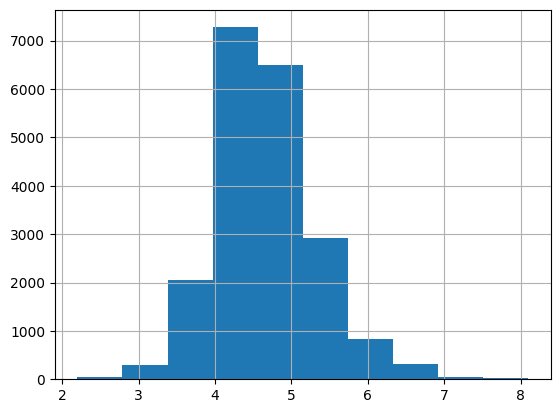

In [18]:
# Should we consider outliers exclusion and logarithm transformation?
milan.query('price > 5 & price < 3500').price.apply(np.log).hist()

In [19]:
# Getting rid of outliers
print("99.5% properties have a price lower than {0: .2f}".format(np.percentile(milan.price, 99.5)))
milan = milan[(milan.price <= np.percentile(milan.price, 99.5)) & (milan.price > 0)]

99.5% properties have a price lower than  1255.37


<Axes: >

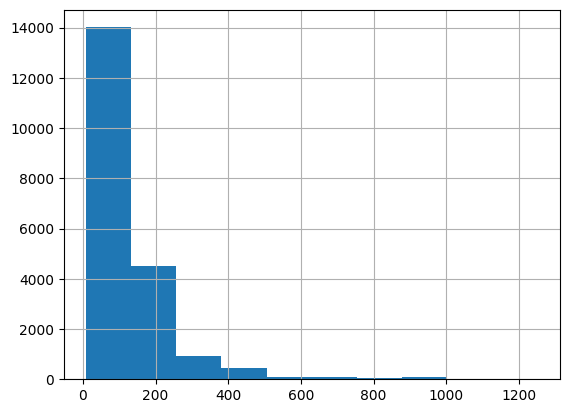

In [20]:
milan.price.hist()

<Axes: >

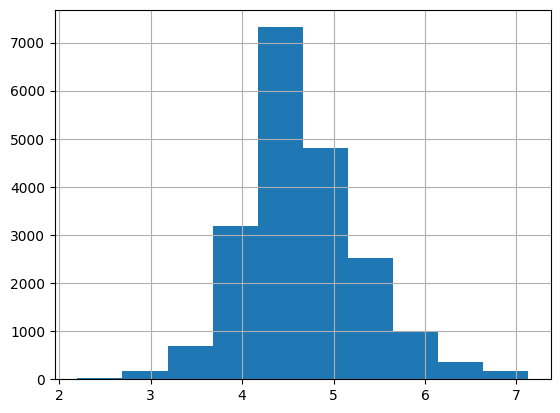

In [21]:
milan['log_price'] = milan.price.apply(np.log)
milan.log_price.hist()

### Exploratory Data Analysis Summary

The distribution of prices is heavily right-skewed, which motivates the use of a logarithmic transformation. Entire homes and hotel rooms exhibit significantly higher prices compared to private and shared rooms. These patterns suggest that both listing type and capacity-related features are key drivers of price variation.


In [22]:

 # how many #na are in our input data
pd.set_option('display.max_rows', None)
milan.isna().sum()

,0
id,0
listing_url,0
scrape_id,0
last_scraped,0
source,0
name,7
description,379
neighborhood_overview,9140
picture_url,0
host_id,0


In [23]:
milan['bathrooms_text']=milan['bathrooms_text'].str.lower()
milan['bathrooms_text'].unique()


array(['1 bath', '1 shared bath', '2 baths', '1.5 baths',
       '1 private bath', nan, '2 shared baths', 'shared half-bath',
       '1.5 shared baths', '3 baths', '2.5 baths', '4 baths', '0 baths',
       '4.5 shared baths', '3 shared baths', '3.5 baths', '5 baths',
       '2.5 shared baths', 'private half-bath', 'half-bath',
       '0 shared baths', '8 baths', '7 baths', '4.5 baths',
       '4 shared baths', '5.5 baths'], dtype=object)

In [25]:
from os import makedirs

new_bathrooms=milan['bathrooms_text'].str.split(' ',n=1, expand=True)
milan['bathrooms'] = new_bathrooms[0]
milan['bathrooms_'] = new_bathrooms[1]
milan.bathrooms = milan.bathrooms.str.replace("half", "0.5")
milan.bathrooms = milan.bathrooms.str.replace("half-bath", "0.5")
milan.bathrooms = milan.bathrooms.str.replace("-bath", "")
milan.bathrooms = milan.bathrooms.str.replace("shared", "0.1")
milan.bathrooms = milan.bathrooms.str.replace("private", "1")
milan.bathrooms = milan.bathrooms.astype("float")


In [27]:
room_map = {
    'Private room': 0,
    'Entire home/apt': 1,
    'Shared room': 2,
    'Hotel room': 3
}

milan['room_type_num'] = milan['room_type'].map(room_map)

In [29]:
milan.host_response_rate = milan.host_acceptance_rate.astype("float")
milan.host_acceptance_rate = milan.host_acceptance_rate.astype("float")
milan.review_scores_accuracy = milan.review_scores_accuracy.astype("float")
milan.review_scores_checkin = milan.review_scores_checkin.astype("float")
milan.review_scores_cleanliness = milan.review_scores_cleanliness.astype("float")
milan.review_scores_communication = milan.review_scores_communication.astype("float")
milan.review_scores_location = milan.review_scores_location.astype("float")
milan.review_scores_rating = milan.review_scores_rating.astype("float")
milan.review_scores_value = milan.review_scores_value.astype("float")
milan.reviews_per_month = milan.reviews_per_month.astype("float")


In [30]:
null_variable =['review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication',
                   'review_scores_location', 'review_scores_value', 'host_response_rate', 'host_acceptance_rate','bathrooms', 'bedrooms','beds']


In [31]:
import numpy as np
from sklearn.impute import SimpleImputer
# Feeding null values by 'median'
impute_it = SimpleImputer(strategy='median')
impute_data = impute_it.fit_transform(milan[null_variable])
milan[null_variable] = impute_data


In [41]:
milan.isna().sum()

,0
id,0
listing_url,0
scrape_id,0
last_scraped,0
source,0
name,7
description,379
neighborhood_overview,9140
picture_url,0
host_id,0


In [32]:
milan['latitude'] = milan['latitude'].astype(float)


In [33]:
milan['latitude'].mean()

np.float64(45.471632536520275)

In [34]:
milan['longitude'] = milan['longitude'].astype(float)


In [35]:
milan['longitude'].mean()

np.float64(9.187690118370293)

In [36]:
milan['is_wifi'] = milan['amenities'].apply(lambda x: 'wifi' in x.lower())*1
milan['is_tv'] = milan['amenities'].apply(lambda x: 'tv' in x.lower())*1

milan['bedrooms2'] = milan.bedrooms**2
milan['n_amenities'] = milan['amenities'].apply(len)

milan['lat_sq_latitude'] = milan['latitude'].apply(lambda x: np.log(x**2+1))
milan['lon_sq_longitude'] = milan['longitude'].apply(lambda x: np.log(x**2+1))

milan['lat_dist_mean'] = milan['latitude'].apply(lambda x: (x-np.mean( milan['latitude']))**2)
milan['lon_dist_mean'] = milan['longitude'].apply(lambda x: (x-np.mean( milan['longitude']))**2)

In [37]:
# get all numeric
all_num_feats = [x for x in milan.dtypes[milan.dtypes != 'object'].index if not ('id' in x) and not ('url' in x) and not ('price' in x) ]
" + ".join(all_num_feats)

'host_response_rate + host_acceptance_rate + host_listings_count + host_total_listings_count + neighbourhood_group_cleansed + latitude + longitude + accommodates + bathrooms + bedrooms + beds + minimum_nights + maximum_nights + minimum_minimum_nights + maximum_minimum_nights + minimum_maximum_nights + maximum_maximum_nights + calendar_updated + availability_30 + availability_60 + availability_90 + availability_365 + number_of_reviews + number_of_reviews_ltm + number_of_reviews_l30d + review_scores_rating + review_scores_accuracy + review_scores_cleanliness + review_scores_checkin + review_scores_communication + review_scores_location + review_scores_value + calculated_host_listings_count + calculated_host_listings_count_entire_homes + calculated_host_listings_count_private_rooms + calculated_host_listings_count_shared_rooms + reviews_per_month + room_type_num + is_wifi + is_tv + bedrooms2 + n_amenities + lat_sq_latitude + lon_sq_longitude + lat_dist_mean + lon_dist_mean'

In [38]:
features_eda = milan.loc[:,['last_scraped','host_is_superhost', 'host_listings_count',
                            'host_has_profile_pic', 'accommodates', 'bathrooms', 'bedrooms', 'beds','log_price',
                              'maximum_minimum_nights', 'availability_60', 'availability_365', 'number_of_reviews', 'instant_bookable', 'calculated_host_listings_count',
                           'review_scores_cleanliness', 'review_scores_location', 'review_scores_value','reviews_per_month',
                           'room_type_num', 'is_wifi', 'is_tv', 'n_amenities']]

In [40]:
corr = features_eda.corr(numeric_only=True)
corr

,host_listings_count,accommodates,bathrooms,bedrooms,beds,log_price,maximum_minimum_nights,availability_60,availability_365,number_of_reviews,calculated_host_listings_count,review_scores_cleanliness,review_scores_location,review_scores_value,reviews_per_month,room_type_num,is_wifi,is_tv,n_amenities
host_listings_count,1.000000,0.080385,0.000856,0.030947,0.029747,0.055490,-0.003614,0.100719,0.088900,-0.066394,0.907172,-0.235043,-0.104439,-0.273687,-0.058331,0.107683,0.057832,0.105022,-0.080134
accommodates,0.080385,1.000000,0.410454,0.622067,0.707683,0.383609,-0.024706,0.040611,0.038824,0.055225,0.066514,-0.044770,-0.026117,-0.032817,0.076373,0.308447,0.073786,0.180929,0.174989
bathrooms,0.000856,0.410454,1.000000,0.588875,0.408389,0.288536,0.015562,0.001825,0.020817,-0.004917,0.001078,0.014584,0.018690,0.018393,-0.016851,0.031059,0.055678,0.041647,0.069608
bedrooms,0.030947,0.622067,0.588875,1.000000,0.634710,0.341153,0.010639,-0.020250,0.005801,0.010697,0.021636,-0.012791,-0.007701,-0.001203,-0.003728,0.121808,0.034620,0.066251,0.071663
beds,0.029747,0.707683,0.408389,0.634710,1.000000,0.257362,0.006120,-0.017440,0.010108,0.047902,0.023188,-0.033618,-0.031343,-0.015841,0.018672,0.197597,0.037562,0.087824,0.128637
log_price,0.055490,0.383609,0.288536,0.341153,0.257362,1.000000,-0.039489,0.265136,0.191284,-0.104632,0.050813,0.055717,0.117057,0.002406,-0.051703,0.225907,0.032175,0.173889,0.060460
maximum_minimum_nights,-0.003614,-0.024706,0.015562,0.010639,0.006120,-0.039489,1.000000,0.009697,0.036893,-0.025577,-0.004970,-0.003943,-0.001632,-0.004411,-0.051175,-0.007496,-0.015523,-0.015330,-0.033354
availability_60,0.100719,0.040611,0.001825,-0.020250,-0.017440,0.265136,0.009697,1.000000,0.619877,-0.074555,0.090717,-0.020749,-0.014472,-0.074567,0.085400,0.061957,0.030299,0.086379,0.156537
availability_365,0.088900,0.038824,0.020817,0.005801,0.010108,0.191284,0.036893,0.619877,1.000000,-0.041146,0.066955,-0.024336,-0.018610,-0.061514,0.052790,0.070918,0.024965,0.102847,0.151068
number_of_reviews,-0.066394,0.055225,-0.004917,0.010697,0.047902,-0.104632,-0.025577,-0.074555,-0.041146,1.000000,-0.063163,0.037586,0.032939,0.073374,0.539856,0.013839,0.094503,0.013950,0.168850


<Axes: >

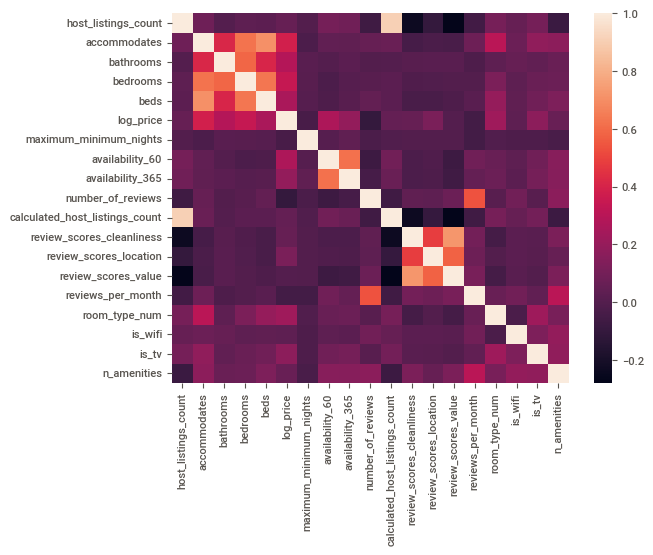

In [ ]:
sns.heatmap(corr)

In [ ]:
X =milan.loc[:,['accommodates', 'bathrooms', 'bedrooms', 'beds', 'n_amenities', 'review_scores_location',
                           'room_type_num', 'is_wifi', 'is_tv']].fillna(0)
X.isna().sum()

accommodates              0
bathrooms                 0
bedrooms                  0
beds                      0
n_amenities               0
review_scores_location    0
room_type_num             0
is_wifi                   0
is_tv                     0
dtype: int64

In [ ]:
X.shape


(20262, 9)

#Target variable

In [ ]:
y = milan['log_price']
y.shape

(20262,)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

In [ ]:
print("Training feature set size:",X_train.shape)
print("Test feature set size:",X_test.shape)
print("Training variable set size:",y_train.shape)
print("Test variable set size:",y_test.shape)

Training feature set size: (16209, 9)
Test feature set size: (4053, 9)
Training variable set size: (16209,)
Test variable set size: (4053,)


In [ ]:
from sklearn import preprocessing
import pandas as pd

scaler = preprocessing.MinMaxScaler()

names = X_train.columns
d = scaler.fit_transform(X_train)

scaled_X = pd.DataFrame(d, columns=names)


MODEL1
MILAN

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn import metrics

In [ ]:
lm = LinearRegression() # Creating a Linear Regression object 'lm'


In [ ]:
lm.fit(scaled_X,y_train) # Fit the linear model on to the 'lm' object itself i.e. no need to set this to another variable

LinearRegression()

In [ ]:
print("The intercept term of the linear model:", lm.intercept_)

The intercept term of the linear model: 2.912081146220384


In [ ]:
print("The coefficients of the linear model:", lm.coef_)

The coefficients of the linear model: [ 1.73467115  1.53857321  1.3878095  -0.77924435 -0.1183597   1.092502
  0.59914157 -0.00207844  0.15055341]


In [ ]:
#idict = {'Coefficients':lm.intercept_}
#idf = pd.DataFrame(data=idict,index=['Intercept'])
cdf = pd.DataFrame(data=lm.coef_, index=X_train.columns, columns=["Coefficients"])
#cdf=pd.concat([idf,cdf], axis=0)
cdf

,Coefficients
accommodates,1.734671
bathrooms,1.538573
bedrooms,1.387809
beds,-0.779244
n_amenities,-0.118360
review_scores_location,1.092502
room_type_num,0.599142
is_wifi,-0.002078
is_tv,0.150553


In [ ]:
n=scaled_X.shape[0]
k=scaled_X.shape[1]
dfN = n-k
train_pred=lm.predict(scaled_X)
train_error = np.square(train_pred - y_train)
sum_error=np.sum(train_error)
se=[0,0,0,0,0,0,0,0,0]
for i in range(k):
    r = (sum_error/dfN)
    r = r/np.sum(np.square(scaled_X[list(scaled_X.columns)[i]]-scaled_X[list(scaled_X.columns)[i]].mean()))
    se[i] = np.sqrt(r)
cdf['Standard Error']=se
cdf['t-statistic']=cdf['Coefficients']/cdf['Standard Error']
cdf

,Coefficients,Standard Error,t-statistic
accommodates,1.734671,0.047057,36.863145
bathrooms,1.538573,0.092333,16.663255
bedrooms,1.387809,0.061057,22.729550
beds,-0.779244,0.056317,-13.836669
n_amenities,-0.118360,0.032077,-3.689914
review_scores_location,1.092502,0.061975,17.628121
room_type_num,0.599142,0.032888,18.217877
is_wifi,-0.002078,0.016768,-0.123956
is_tv,0.150553,0.011661,12.911115


In [ ]:
print("Therefore, features arranged in the order of importance for predicting the house price\n",'-'*90,sep='')
l=list(cdf.sort_values('t-statistic',ascending=False).index)
print(' > \n'.join(l))

Therefore, features arranged in the order of importance for predicting the house price
------------------------------------------------------------------------------------------
accommodates > 
bedrooms > 
room_type_num > 
review_scores_location > 
bathrooms > 
is_tv > 
is_wifi > 
n_amenities > 
beds


MODEL2 MILAN

In [ ]:
train_milan =pd.concat([X_train, y_train], axis = 1)


In [ ]:
model = smf.ols('''y_train ~
                    accommodates + bathrooms + bedrooms + beds + review_scores_location +
                           room_type_num + is_wifi + is_tv''',
                            data=train_milan).fit()

# Inspect the results
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                y_train   R-squared:                       0.214
Model:                            OLS   Adj. R-squared:                  0.214
Method:                 Least Squares   F-statistic:                     552.7
Date:                Fri, 23 Jun 2023   Prob (F-statistic):               0.00
Time:                        13:42:50   Log-Likelihood:                -14144.
No. Observations:               16209   AIC:                         2.831e+04
Df Residuals:                   16200   BIC:                         2.837e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  2

The OLS model shows statistically significant effects for most capacity and location-related features. However, the presence of correlated variables leads to moderate explanatory power and coefficient instability.


(7.630325141352547e-06,
 0.410843139833684,
 -0.07764159778979855,
 0.18065136247354932)

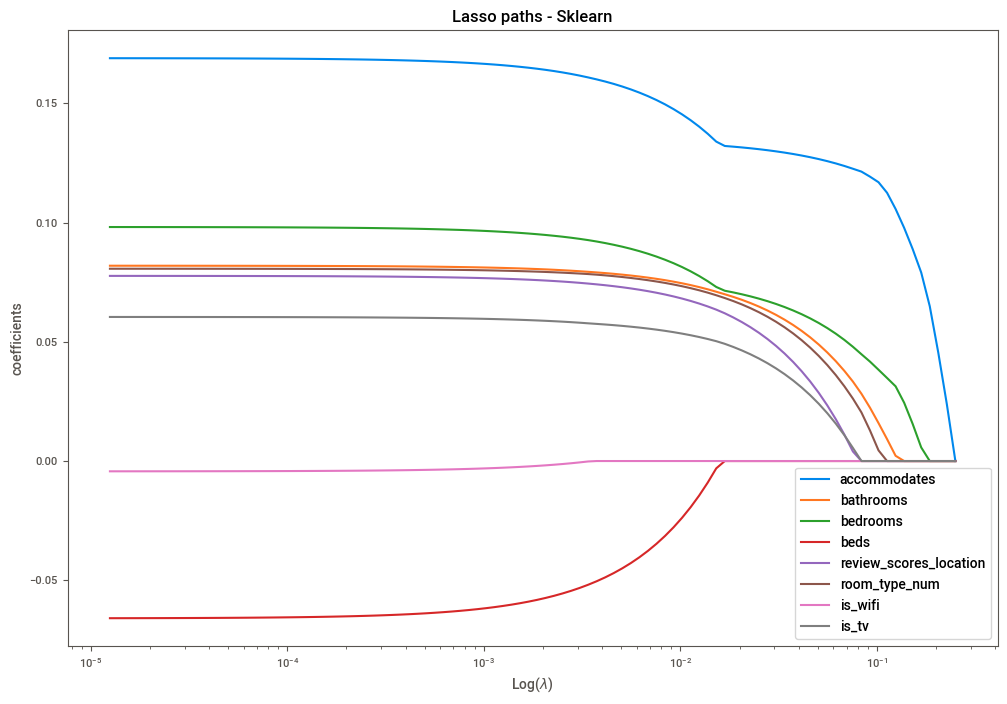

In [ ]:
# Lasso

variables = ['accommodates', 'bathrooms', 'bedrooms', 'beds', 'review_scores_location',
                           'room_type_num', 'is_wifi', 'is_tv']
data_subset = X.loc[:, variables]
data_subset.dropna(inplace=True)

A = data_subset.loc[:,variables]
A = preprocessing.scale(A)
b = np.array(y)

alphas_lasso, coefs_lasso, _ = lasso_path(A, b, eps = 5e-5)

# Display results
plt.figure(figsize = (12,8))

for i in range(A.shape[1]):
    plt.plot(alphas_lasso, coefs_lasso[i], label = variables[i])

plt.xscale('log')
plt.xlabel('Log($\\lambda$)')
plt.ylabel('coefficients')
plt.title('Lasso paths - Sklearn')
plt.legend()
plt.axis('tight')

Lasso regularization confirms that only a subset of variables provides stable predictive signal, highlighting redundancy among capacity-related features.


In [ ]:
predicted = model.predict(X_test)
mean_squared_error(y_test, predicted)

0.32387349019421435

In [ ]:
print("Mean absolute error (MAE):", metrics.mean_absolute_error(y_test,predicted))
print("Mean square error (MSE):", metrics.mean_squared_error(y_test,predicted))
print("Root mean square error (RMSE):", np.sqrt(metrics.mean_squared_error(y_test,predicted)))

Mean absolute error (MAE): 0.4263967905918469
Mean square error (MSE): 0.32387349019421435
Root mean square error (RMSE): 0.5690988404435686


In [ ]:
print("R-squared value of predictions:",round(metrics.r2_score(y_test,predicted),3))

R-squared value of predictions: 0.234




XGBoost

In [ ]:
dtrain = xgboost.DMatrix(X_train, label=y_train)


model = xgboost.XGBRegressor(n_estimators=200, verbosity=1)

model.fit(X_train,y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=200, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [ ]:
predicted = model.predict(X_test)
mean_squared_error(y_test, predicted)

0.30474870666599235

In [ ]:
print("Mean absolute error (MAE):", metrics.mean_absolute_error(y_test,predicted))
print("Mean square error (MSE):", metrics.mean_squared_error(y_test,predicted))
print("Root mean square error (RMSE):", np.sqrt(metrics.mean_squared_error(y_test,predicted)))

Mean absolute error (MAE): 0.4137731066773193
Mean square error (MSE): 0.30474870666599235
Root mean square error (RMSE): 0.5520404936832011


In [ ]:
print("R-squared value of predictions:",round(metrics.r2_score(y_test,predicted),3))

R-squared value of predictions: 0.279


## Conclusion

This project analyzed the determinants of Airbnb listing prices in Milan using both linear and non-linear models. Capacity-related features, room type, and location scores were found to be the primary drivers of price variation. While regularization improved coefficient stability, more complex models such as XGBoost did not significantly outperform linear regression due to limited feature richness.

These findings demonstrate that model interpretability and data quality can be more important than algorithmic complexity when feature availability is constrained.

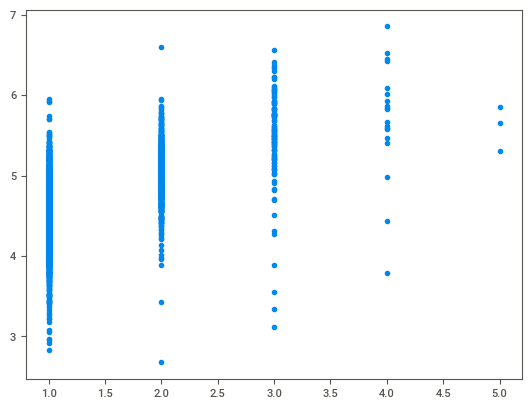

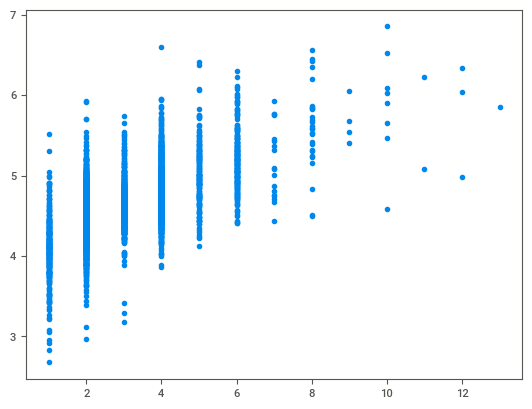

In [ ]:
plt.scatter(x=X_test.bedrooms, y=predicted)
plt.show()
plt.scatter(x=X_test.accommodates, y=predicted)
plt.show()

In [ ]:
#Playing with Shapley values
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

In [ ]:
X_test.iloc[0,:]

accommodates                2.00
bathrooms                   1.00
bedrooms                    1.00
beds                        1.00
n_amenities               217.00
review_scores_location      4.76
room_type_num               1.00
is_wifi                     1.00
is_tv                       0.00
Name: 6881, dtype: float64

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test.iloc[0,:])

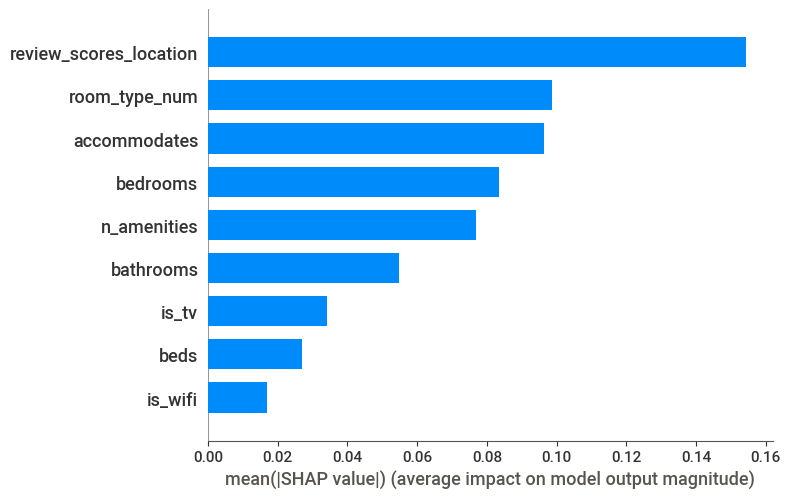

In [ ]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

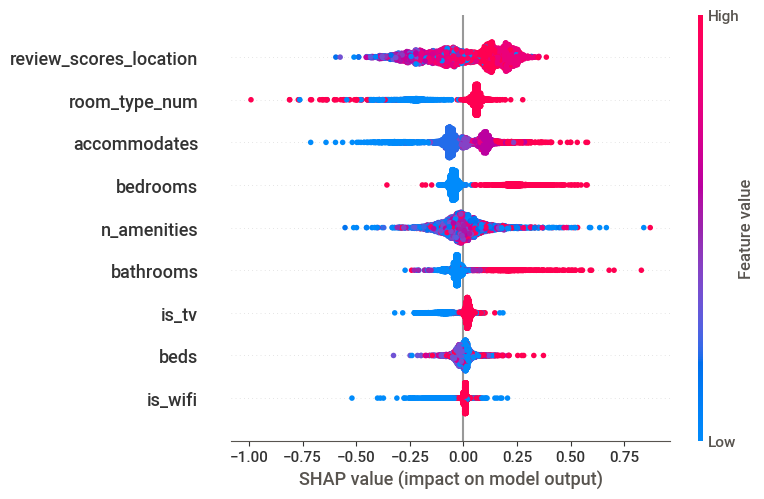

In [ ]:
shap.summary_plot(shap_values, features=X_test, feature_names=X_test.columns)